In [72]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


### Import and Setup

In [73]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

#### Load Pretrained ResNet50 (Feature Extractor)

In [74]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove final classification layer
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Image Processing Pipeline

In [75]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [76]:
IMAGE_DIR = "../data/images"
image_ids = [img.split(".")[0] for img in os.listdir(IMAGE_DIR)]

In [77]:
features = {}
with torch.no_grad():
    for img_id in tqdm(image_ids):
        img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0)

        embedding = resnet(image)
        embedding = embedding.view(-1).numpy()

        features[int(img_id)] = embedding

  0%|          | 0/3993 [00:00<?, ?it/s]

100%|██████████| 3993/3993 [06:01<00:00, 11.05it/s]


#### Saving the Embeddings

In [78]:
np.save("../data/processed/image_embeddings.npy", features)

In [132]:
tabular_df = pd.read_csv("../data/processed/train_clean.csv")
tabular_df = tabular_df.drop(columns=["date"])

In [133]:
image_features = np.load(
    "../data/processed/image_embeddings.npy",
    allow_pickle=True
).item()

In [134]:
img_df = pd.DataFrame.from_dict(image_features, orient="index")
img_df.index.name = "id"
img_df.reset_index(inplace=True)

#### Merge Tabular + Image Data

In [135]:
merged_df = tabular_df.merge(img_df, on="id", how="inner")
print("Merged shape:", merged_df.shape)

Merged shape: (4036, 532)


#### Prepare X and y

In [136]:
X = merged_df.drop(columns=["price", "id"])
y = merged_df["price"]
y = np.log1p(y)
X.columns = X.columns.astype(str)

#### Quick Feature Engineering

In [137]:
X["house_density"] = X["sqft_living"] / X["sqft_lot"]

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Multimodal Regression Model

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_multi = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)

rf_multi.fit(X_train, y_train)

y_pred = rf_multi.predict(X_val)

# Inverse transform
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred)

# Compute RMSE in original units
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
r2 = r2_score(y_val_original, y_pred_original)

print("Multimodal RMSE:", rmse)
print("Multimodal R2:", r2)

Multimodal RMSE: 159758.8172373227
Multimodal R2: 0.7753838060068935


##### In MLP, we won't use log-transform since in log space, the values explode unboundedly and leads to problems so we will keep it in normal y values.

In [140]:
X = merged_df.drop(columns=["price", "id"])
y = merged_df["price"]
X.columns = X.columns.astype(str)

In [141]:
X["house_density"] = X["sqft_living"] / X["sqft_lot"]

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [143]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#### MLP Regressor

In [144]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10
)

mlp.fit(X_train_scaled, y_train)

c:\Users\Sumit Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=300,
             random_state=42)

In [145]:
y_pred = mlp.predict(X_val_scaled)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Multimodal (MLP) RMSE:", rmse)
print("Multimodal (MLP) R2:", r2)

Multimodal (MLP) RMSE: 193172.6855240752
Multimodal (MLP) R2: 0.6716002439320894


#### Apply PCA to embeddings + Ridge Regression

##### Here, we can again use log transform on target variable.

In [146]:
image_cols = img_df.columns.drop("id")

In [147]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=42)
img_pca = pca.fit_transform(img_df[image_cols])

img_pca_df = pd.DataFrame(
    img_pca,
    columns=[f"img_pca_{i}" for i in range(20)]
)
img_pca_df["id"] = img_df["id"]

In [148]:
merged_pca_df = tabular_df.merge(img_pca_df, on="id", how="inner")

X = merged_pca_df.drop(columns=["price", "id"])
y = merged_pca_df["price"]
y= np.log1p(y)

X.columns = X.columns.astype(str)

In [149]:
X["house_density"] = X["sqft_living"] / X["sqft_lot"]

In [150]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)

# Inverse transform
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred)

# Compute RMSE in original units
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
r2 = r2_score(y_val_original, y_pred_original)

print("Multimodal (PCA + Ridge) RMSE:", rmse)
print("Multimodal (PCA + Ridge) R2:", r2)

Multimodal (PCA + Ridge) RMSE: 170288.147961695
Multimodal (PCA + Ridge) R2: 0.744800255536904


## Prediction (Based on tabular data since it gave the best results)

In [151]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../data/processed/train_clean.csv")
test_df  = pd.read_csv("../data/processed/test_clean.csv")

# Drop date column (important)
train_df = train_df.drop(columns=["date"], errors="ignore")
test_df  = test_df.drop(columns=["date"], errors="ignore")

In [152]:
X_train = train_df.drop(columns=["price", "id"])
y_train = np.log1p(train_df["price"])

X_test = test_df.drop(columns=["id"])

In [153]:
X_train["house_density"] = X_train["sqft_living"] / X_train["sqft_lot"]
X_test["house_density"] = X_test["sqft_living"] / X_test["sqft_lot"]

In [154]:
from sklearn.ensemble import RandomForestRegressor

final_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [155]:
test_preds_log = final_model.predict(X_test)

# Convert back to real prices
test_preds = np.exp(test_preds_log)

In [156]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_preds
})

submission.to_csv("../23123042_final.csv", index=False)

## Explainability with Grad-CAM

In [157]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [158]:
# Load pretrained ResNet
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [159]:
target_layer = resnet.layer4

In [160]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [161]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output.mean()
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().numpy()

        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

In [162]:
gradcam = GradCAM(resnet, target_layer)

def run_gradcam(img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)
    cam = gradcam.generate(input_tensor)
    return image, cam


In [163]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_gradcam(image, cam, title_suffix=""):
    img = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam), cv2.COLORMAP_JET
    )
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.title(f"Original {title_suffix}")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM {title_suffix}")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#### Showing Grad-Cam for five sample images

c:\Users\Sumit Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


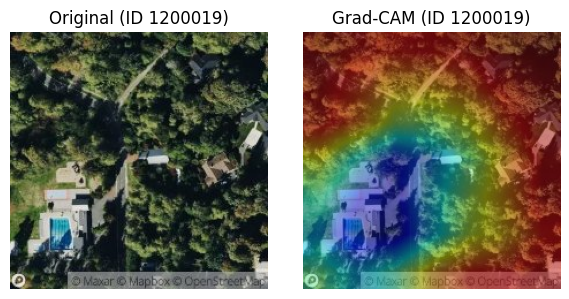

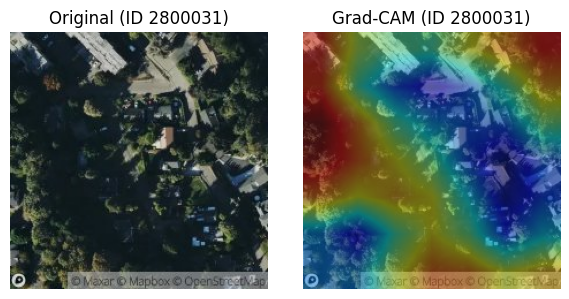

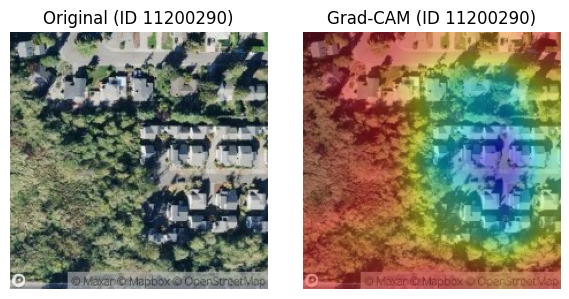

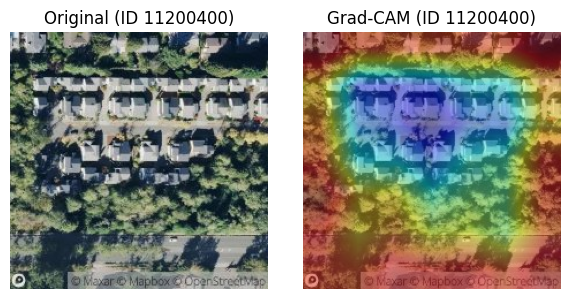

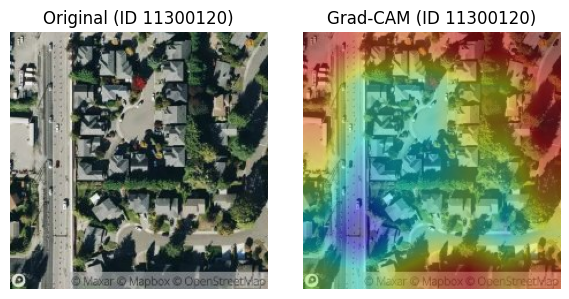

In [164]:
sample_ids = ["1200019", "2800031", "11200290","11200400","11300120"]

for img_id in sample_ids:
    img_path = f"../data/images/{img_id}.png"
    image, cam = run_gradcam(img_path)
    visualize_gradcam(image, cam, title_suffix=f"(ID {img_id})")

Grad-CAM visualizations reveal that the CNN consistently focuses on high-level environmental features such as water proximity, vegetation density, and road structures, confirming that satellite imagery encodes meaningful neighborhood context relevant to property valuation.